In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
cd ../src

/home/tviel/work/kaggle_rsna_lumbar_spine/src


/home/tviel/.local/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [3]:
import os
import cv2
import json
import glob
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch.nn.functional as F

from collections import Counter
from tqdm.notebook import tqdm


pd.set_option('display.width', 500)
pd.set_option('max_colwidth', 100)
pd.set_option('display.max_columns', 100)

In [15]:
from params import *

from data.preparation import *
from data.dataset import *
from data.transforms import get_transfos

from util.plots import *
from util.logger import Config
from util.torch import load_model_weights

from model_zoo.models_seg import define_model

In [16]:
# prepare_folds()

In [20]:
df = prepare_data_crop(DATA_PATH, crop_folder="../input/crops_fix/")

In [38]:
# df = prepare_data_ss_crop(crop_folder="../input/crops_fix/")

In [40]:
# df = prepare_data_ss(explode=True)

In [ ]:
# img = np.load("../input/npy/10728036_142859125.npy")
# img2 = np.load("../input/npy/10728036_2073726394.npy")
# for i in range(0, len(img), 10):
#     plt.figure(figsize=(5, 5))
#     plt.imshow(img[i], cmap="gray")
#     plt.axis(False)
#     plt.show()

In [ ]:
# df[df[CLASSES_SS_NOLVL].sum(1) < 0]

In [ ]:
# df[df['target'].apply(len) != 2]

In [ ]:
# df = prepare_data_scs(DATA_PATH, explode=False)
# plt.figure(figsize=(20, 5))
# for i, c in enumerate(CLASSES_SCS):
#     plt.subplot(1, len(CLASSES_SCS), i + 1)
#     sns.countplot(x=df[c])
# plt.show()

In [ ]:
df = prepare_data_scs(DATA_PATH, "../input/crops_2/")

# df = prepare_data_nfn(DATA_PATH, "../input/crops_2/")

In [ ]:
df[df.isna().sum(1) > 0]

In [ ]:
df.head(1)

In [ ]:
# df[df["coords_crop"].apply(np.sum) < 0]

In [ ]:
# df = prepare_data_scs(DATA_PATH, None, explode=False)
df = prepare_data_nfn(DATA_PATH, None, explode=False, left_right=True)

In [ ]:
df[df.isna().sum(1) > 0]

### Dataset

In [27]:
# transfos = get_transfos(augment=False, resize=(384, 384), crop=False)
transfos = get_transfos(augment=False, resize=(224, 224), crop=False)

In [28]:
# df = prepare_data_ss(explode=True)

# dataset = ImageDataset(
#     df,
#     CLASSES_SS_NOLVL,
#     transforms=transfos,
#     frames_chanel=1,
#     n_frames=1,
#     stride=1,
#     train=True,
#     load_in_ram=False,
# )

In [29]:
# df = prepare_data_nfn(DATA_PATH, None, explode=False, left_right=True)

# dataset = ImageDataset(
#     df,
#     CLASSES_NFN_NOSIDE,
#     transforms=transfos,
#     frames_chanel=1,
#     n_frames=1,
#     stride=1,
#     train=True,
#     load_in_ram=False,
# )

In [59]:
# # df = prepare_data_scs(DATA_PATH, "../input/crops_fix/")
df = prepare_data_crop(DATA_PATH, crop_folder="../input/crops_fix/")
# df = prepare_data_nfn(DATA_PATH, "../input/crops_fix/")


dataset = CropDataset(
    df,
    "target",
    transforms=transfos,
    frames_chanel=1,
    n_frames=5,
    stride=1,
    train=True,
    load_in_ram=False,
)

In [60]:
for i in tqdm(range(len(dataset))):
    x, y, y_aux = dataset[i]
    break
    # print(y_aux)

    if i > 1:
        break

  0%|          | 0/19770 [00:00<?, ?it/s]

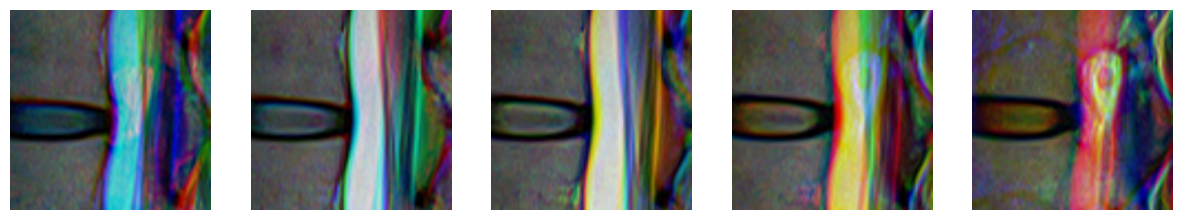

In [61]:
x, y, y_aux = dataset[0]

try:
    img = x.numpy().transpose(0, 2, 3, 1)

    plt.figure(figsize=(15, 5))
    for f in range(len(img)):
        plt.subplot(1, len(img), f + 1)
        plt.imshow(img[f])
        plt.axis(False)
    plt.show()

except:
    img = x.numpy().transpose(1, 2, 0)
    plt.figure(figsize=(15, 5))
    plt.imshow(img)
    plt.axis(False)
    plt.show()

### Loss

In [ ]:
from training.losses import SpineLoss

In [ ]:
loss_config = {
    "name": "series",
    "weighted": False,
    "use_any": False,
    "smoothing": 0.0,
    "activation": "series",
    "aux_loss_weight": 0.0,
    "name_aux": "study",
    "smoothing_aux": 0.0,
    "activation_aux": "",
}

loss = SpineLoss(loss_config)

In [ ]:
y = dataset[1][1].unsqueeze(0)
y

In [ ]:
x = torch.randn(1, 15)

In [ ]:
# loss(x, x, y, y)

### Model

In [ ]:
from model_zoo.models import define_model
from util.torch import count_parameters

In [ ]:
model = define_model(
    "coat_lite_medium",  # "coatnet_rmlp_2_rw_384",  # "coatnet_1_rw_224",
    pooling="flatten",
    head_3d=None,
    n_frames=1,
    num_classes=3,
    n_channels=3,
    drop_rate=0.2,
    reduce_stride=False,
)

In [ ]:
count_parameters(model)

In [ ]:
x, y, _ = dataset[0]
x = x.unsqueeze(0)

In [ ]:
pred, _ = model(x)

In [ ]:
pred.size()

### Inf

In [66]:
from inference.lvl1 import *

In [ ]:
EXP_FOLDER = "../logs/2024-08-04/33/"


In [ ]:
df = prepare_data_scs(DATA_PATH, explode=False)

In [ ]:
# kfold_inference(df, EXP_FOLDER, batch_size=16, debug=True, save=True, use_fp16=True)

In [ ]:
EXP_FOLDER = "../logs/2024-08-05/27/"

In [ ]:
df = prepare_data_nfn(DATA_PATH, explode=False)

In [ ]:
# kfold_inference(df, EXP_FOLDER, batch_size=16, debug=True, save=False, use_fp16=True, left_right=True)

In [ ]:
EXP_FOLDER = "../logs/2024-08-06/15/"

In [ ]:
df = prepare_data_ss(DATA_PATH, explode=False)

#### Crop models

In [62]:
# p = kfold_inference(df, EXP_FOLDER, batch_size=16, debug=True, save=True, use_fp16=True, use_aux=True)

In [67]:
# EXP_FOLDER = "../logs/2024-08-07/19/"
# df = prepare_data_scs(DATA_PATH, "../input/crops_fix/")

# EXP_FOLDER = "../logs/2024-08-07/32/"
# df = prepare_data_nfn(DATA_PATH, "../input/crops_fix/")


EXP_FOLDER = "../logs/2024-08-21/8/"
df = prepare_data_crop(DATA_PATH, "../input/crops_fix/")

if "fold" not in df.columns:
    folds = pd.read_csv("../input/folds_4.csv")
    df = df.merge(folds, how="left")
    df_val = df[df['fold'] == 0].reset_index(drop=True)

In [73]:
p = kfold_inference_crop(df, EXP_FOLDER, batch_size=16, debug=True, save=True, use_fp16=True)


- Fold 1

 -> Loading encoder weights from ../logs/2024-08-21/8/coatnet_1_rw_224_0.pt


 -> Fold 0 - Average AUC: 0.8993


In [ ]:
# from util.metrics import disk_auc

# pred_inf = np.load(EXP_FOLDER + "preds_inf_0.npy")
# pred_inf2 = np.load(EXP_FOLDER + "pred_inf_0.npy")
# pred_val = np.load(EXP_FOLDER + "pred_val_0.npy")

# print("DELTAS")

# print(np.abs(pred_inf - pred_val).max())
# print(np.abs(pred_inf - pred_inf2).max())
# print(np.abs(pred_val - pred_inf2).max())

# print('AUCS')

# print(
#     disk_auc(df_val["target"].values, pred_val)
# )
# print(
#     disk_auc(df_val["target"].values, pred_inf2)
# )
# print(
#     disk_auc(df_val["target"].values, pred_inf)
# )

### Eval

In [ ]:
df = prepare_data()

In [ ]:
df_train = pd.read_csv(DATA_PATH + "train.csv")
for c in df_train.columns[1:]:
    df_train[c] = df_train[c].map(dict(zip(SEVERITIES, [0, 1, 2]))).fillna(-1)
df_train = df_train.astype(int)
df_train = df_train.set_index("study_id")

In [ ]:
for col in df_train.columns:
    c = dict(Counter(df_train[col].values))
    print(col, "\t", c[0], c[1], c[2])

In [ ]:
from sklearn.metrics import log_loss, roc_auc_score
from tqdm.notebook import tqdm
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

In [ ]:
EXP_FOLDER_NFN = "../logs/2024-08-05/27/"

EXP_FOLDER_SCS = "../logs/2024-08-04/33/"

EXP_FOLDER_SS = "../logs/2024-08-06/17/"

In [ ]:
all_preds, all_truths = [], []
for study, df_study in tqdm(df.groupby('study_id')):
    # Get study
    try:
        series_scs = df_study.set_index("series_description")['series_id']['Sagittal T2/STIR']
    except:
        continue  # TODO: fix

    try:
        series_nfn = df_study.set_index("series_description")['series_id']['Sagittal T1']
    except:
        continue  # TODO: fix

    try:
        series_ss = df_study.set_index("series_description")['series_id']['Axial T2']
    except:
        continue  # TODO: fix

    # Load
    try:
        preds_scs = np.load(EXP_FOLDER_SCS+ f'preds/{study}_{series_scs}.npy')
    except:
        preds_scs = np.mean(
            [np.load(EXP_FOLDER_SCS + f'preds/{study}_{s}.npy') for s in series_scs.values], 0
        )
    try:
        preds_nfn = np.load(EXP_FOLDER_NFN + f'preds/{study}_{series_nfn}.npy')
    except:
        preds_nfn = np.mean(
            [np.load(EXP_FOLDER_NFN + f'preds/{study}_{s}.npy') for s in series_nfn.values], 0
        )

    try:
        preds_ss = np.load(EXP_FOLDER_SS + f'preds/{study}_{series_ss}.npy')
        preds_ss_aux = np.load(EXP_FOLDER_SS + f'preds_aux/{study}_{series_ss}.npy')
    except:
        preds_ss = np.mean(
            [np.load(EXP_FOLDER_SS + f'preds/{study}_{s}.npy') for s in series_ss.values[:1]], 0
        )
        preds_ss_aux = np.mean(
            [np.load(EXP_FOLDER_SS + f'preds_aux/{study}_{s}.npy') for s in series_ss.values[:1]], 0
        )

    assert preds_nfn.min() >= 0
    assert preds_ss.min() >= 0
    assert preds_scs.min() >= 0

    # Aggregate preds
    preds = {}
    for i, c in enumerate(CLASSES_SCS):
        p = preds_scs[:, i].max(0)
        # p[0] = 1 - p[1] - p[2]
        p = np.array(p) / np.sum(p)
        preds[c] = p
        
        assert np.min(p) >= 0

    for i, c in enumerate(CLASSES_NFN_NOSIDE):
        p_right = preds_nfn[:len(preds_nfn) // 2, i].max(0)
        # p_right[0] = 1 - p_right[1] - p_right[2]
        p_right = np.array(p_right) / np.sum(p_right)

        p_left = preds_nfn[len(preds_nfn) // 2:, i].max(0)
        # p_left[0] = 1 - p_left[1] - p_left[2]
        p_left = np.array(p_left) / np.sum(p_left)

        preds[f"right_{c}"] = p_right
        preds[f"left_{c}"] = p_left

        assert np.min(p_left) >= 0
        assert np.min(p_right) >= 0

    for i, c in enumerate(CLASSES_SS_NOLVL):
        for lv, lvl in enumerate(LEVELS_):
            p = (preds_ss[:, i] * preds_ss_aux[:, lv][:, None]).max(0)
            p = np.array(p) / np.sum(p)
            p[0] = 1 - p[1] - p[2]
            preds[c + "_" + lvl] = p

    y = df_train.loc[study].to_dict()

    all_preds.append(preds)
    all_truths.append(y)
    # break

df_preds = pd.DataFrame(all_preds)
df_gt = pd.DataFrame(all_truths)

In [ ]:
losses = {}
for c in df_preds.columns:
    aucs = []

    preds = np.vstack(df_preds[c].values)
    y = df_gt[c].values

    preds = preds[y > -1]
    y = y[y > -1]

    # Rescale with loss weights
    # model = LogisticRegression(C=100, class_weight={0: 1, 1:2, 2: 4}, fit_intercept=False, random_state=0)
    model = LogisticRegressionCV(Cs=[1, 10, 100], class_weight={0: 1, 1:2, 2: 4}, fit_intercept=False, random_state=0)
    preds = np.ones((len(y), 3))
    model.fit(preds, y)
    preds = model.predict_proba(preds)

    for i in range(3):
        auc = roc_auc_score(y == i, preds[:, i])
        aucs.append(auc)

    loss = log_loss(
        y,
        preds,
        sample_weight=2 ** y,
        labels=[0, 1, 2],
    )
    
    print(f'-> {c} \n - AUC:  {np.mean(aucs) :.3f} \n - Loss: {loss:.3f}\n')
    losses[c] = loss

In [ ]:
losses_agg = {}

severe_spinal_preds, severe_spinal_gts = [], []
for c in CLASSES_SCS:
    severe_spinal_preds.append(np.vstack(df_preds[c].values)[:, 2])
    severe_spinal_gts.append(df_gt[c].values)

severe_spinal_preds = np.max(severe_spinal_preds, 0)
severe_spinal_gts = np.max(severe_spinal_gts, 0).astype(int)
auc = roc_auc_score(severe_spinal_gts == 2, severe_spinal_preds)

loss = log_loss(
    severe_spinal_gts == 2,
    severe_spinal_preds,
    sample_weight=2 ** severe_spinal_gts,
    labels=[0, 1],
)

losses_agg["any_severe_spinal"] = loss
print(f'-> any_severe_spinal \n - AUC:  {auc :.3f} \n - Loss: {loss:.3f}\n')

In [ ]:
for s in ["spinal_canal_stenosis", "neural_foraminal_narrowing", "subarticular_stenosis"]:
    losses_agg[s] = np.mean([losses[k] for k in losses if s in k])

    print(f'-> Loss - {s} \t: {losses_agg[s] :.3f}\n')

In [ ]:
print(f'\n-> CV loss: {np.mean(list(losses_agg.values())):.3f}')

In [ ]:
from util.metrics import rsna_loss

preds = []
for c in df_gt.columns:
    p = np.vstack(df_preds[c].values)[:, None]
    # print(c, p.min(), p.max())
    preds.append(p)
preds = np.concatenate(preds, 1)

rsna_loss(df_gt.values, preds)

Done ! 